In [5]:
# Imports
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
from google.colab import files
import zipfile
import os

# Upload the zip file
uploaded = files.upload()

# Get the file name from the uploaded file
zip_file_name = list(uploaded.keys())[0]

# Extract the zip file
extract_folder = '/content/dataset'
os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Dataset extracted to: {extract_folder}")


Saving spambase.zip to spambase (1).zip
Dataset extracted to: /content/dataset


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load the dataset (assuming it's named 'spambase.data')
csv_path = '/content/dataset/spambase.data'  # Adjust path if needed
df = pd.read_csv(csv_path, header=None)

# Assign column names
columns = [f"feature_{i}" for i in range(57)] + ["label"]
df.columns = columns

# Split into features (X) and target (y)
X = df.drop(columns=['label'])
y = df['label']

# Train-test split (70-30 split for example)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Define the base models
nb = GaussianNB()
svm = SVC(kernel='linear', probability=True)

# Step 2: Hyperparameter tuning with GridSearchCV for Naive Bayes
nb_param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}
nb_grid = GridSearchCV(nb, nb_param_grid, cv=5)
nb_grid.fit(X_train_sm, y_train_sm)

# Step 3: Hyperparameter tuning with GridSearchCV for SVM
svm_param_grid = {'C': [0.1, 1, 10]}
svm_grid = GridSearchCV(svm, svm_param_grid, cv=5)
svm_grid.fit(X_train_sm, y_train_sm)

# Step 4: Combine base models using StackingClassifier
base_learners = [('naive_bayes', nb_grid.best_estimator_),
                 ('svm', svm_grid.best_estimator_)]

# Step 5: Stacking model (meta-model: Logistic Regression)
stacked_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

# Step 6: Train the stacked model
stacked_model.fit(X_train_sm, y_train_sm)

# Step 7: Make predictions and evaluate the performance
stacked_preds = stacked_model.predict(X_test)

# Step 8: Evaluate with confusion matrix and classification report
print("Hybrid Stacking Model (with GridSearchCV) Results:")
print(confusion_matrix(y_test, stacked_preds))
print(classification_report(y_test, stacked_preds))


Hybrid Stacking Model (with GridSearchCV) Results:
[[758  46]
 [ 49 528]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       804
           1       0.92      0.92      0.92       577

    accuracy                           0.93      1381
   macro avg       0.93      0.93      0.93      1381
weighted avg       0.93      0.93      0.93      1381



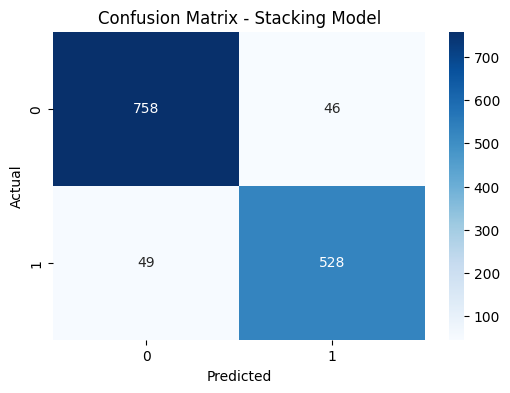

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, stacked_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Stacking Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


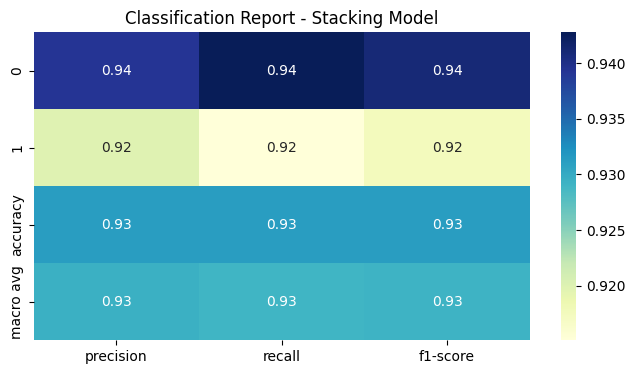

In [10]:
from sklearn.metrics import classification_report
import pandas as pd

# Classification report
stacked_report_dict = classification_report(y_test, stacked_preds, output_dict=True)
stacked_report_df = pd.DataFrame(stacked_report_dict).transpose()

# Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(stacked_report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title('Classification Report - Stacking Model')
plt.show()


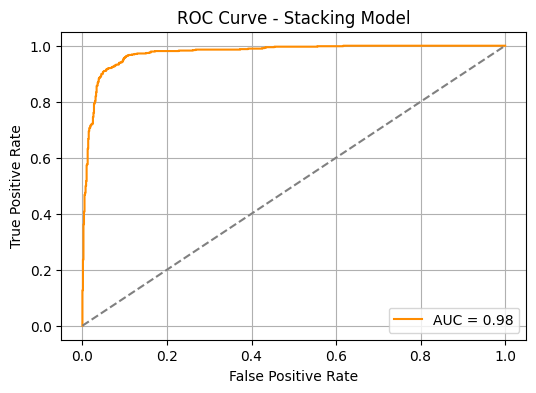

In [11]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for positive class
stacked_probs = stacked_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


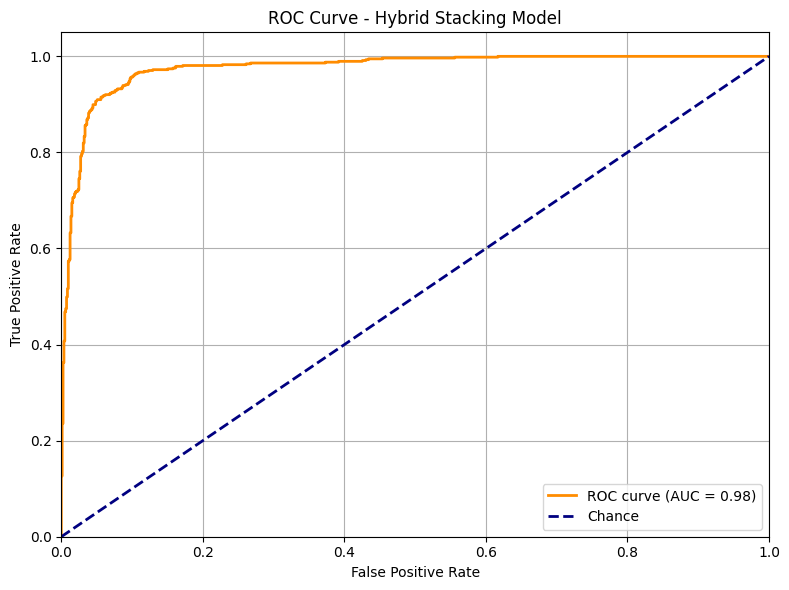

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities for class 1 only
stacked_probs = stacked_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Hybrid Stacking Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
